In [ ]:
# import necessary libraries
import pandas as pd 
import numpy as np
import pickle
import torch
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import 
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
import os
import random
import keras_tuner as kt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# load data
path = "../datasets/CNAP_blood_pressure.csv"

df = pd.read_csv(path)
df.head()

,ecg_0,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,...,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,SBP,DBP,subject,trial
0,-784.0,-754.0,-732.0,-715.0,-689.0,-671.0,-658.0,-646.0,-638.0,-637.0,...,56603.0,56608.0,56612.0,56581.0,56551.0,56557.0,131.607056,58.044434,0,1.0
1,686.0,680.0,298.0,-294.0,-688.0,-596.0,-101.0,442.0,717.0,715.0,...,56247.0,56227.0,56203.0,56213.0,56224.0,56207.0,131.607056,58.044434,0,1.0
2,590.0,560.0,107.0,-534.0,-871.0,-632.0,-32.0,511.0,748.0,740.0,...,56374.0,56364.0,56351.0,56373.0,56399.0,56397.0,127.789307,57.366943,0,1.0
3,633.0,582.0,164.0,-412.0,-729.0,-529.0,17.0,523.0,724.0,691.0,...,56939.0,56922.0,56904.0,56922.0,56942.0,56930.0,128.906250,55.453491,0,1.0
4,694.0,424.0,-138.0,-671.0,-805.0,-463.0,119.0,573.0,695.0,653.0,...,56378.0,56367.0,56388.0,56408.0,56394.0,56378.0,125.912476,55.142212,0,1.0


In [3]:
df.describe()

,ecg_0,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,...,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,SBP,DBP,subject,trial
count,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,...,16047.00000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000
mean,1066.188945,431.663613,-1184.575871,-2584.160404,-2717.941609,-1756.763881,-644.251387,52.182402,383.462890,527.773914,...,43437.17536,43437.930953,43438.393968,43438.538605,43438.402817,43438.024553,123.233116,65.425236,3.436219,2.504393
std,596.022072,535.347140,1113.145288,1764.257444,1902.970274,1624.898566,1101.846380,532.029296,249.209632,288.587199,...,18823.48963,18824.907741,18826.414014,18827.809178,18828.936537,18829.911345,17.885018,12.599646,2.226186,1.117698
min,-5336.000000,-3104.000000,-5561.000000,-8135.000000,-8159.000000,-7152.000000,-4674.000000,-2434.000000,-1592.000000,-1497.000000,...,19505.00000,19481.000000,19474.000000,19463.000000,19443.000000,19433.000000,72.106934,27.767944,0.000000,1.000000
25%,641.000000,143.000000,-1963.500000,-3912.500000,-4168.500000,-2798.500000,-1271.500000,-216.000000,226.000000,323.000000,...,27992.50000,27994.500000,27999.500000,27995.000000,27992.500000,27983.000000,111.749268,56.675720,2.000000,2.000000
50%,780.000000,418.000000,-931.000000,-2302.000000,-2233.000000,-1286.000000,-169.000000,157.000000,344.000000,491.000000,...,35665.00000,35665.000000,35669.000000,35671.000000,35664.000000,35662.000000,123.074341,64.022827,3.000000,3.000000
75%,1637.500000,656.000000,-244.000000,-1088.500000,-1337.500000,-460.500000,129.000000,391.000000,499.000000,716.000000,...,59455.50000,59460.000000,59467.000000,59476.000000,59479.000000,59481.000000,133.680725,73.104858,5.000000,4.000000
max,4394.000000,3014.000000,1375.000000,946.000000,838.000000,1112.000000,2779.000000,2688.000000,2597.000000,2754.000000,...,83872.00000,83911.000000,83950.000000,83938.000000,83925.000000,83961.000000,191.830444,123.944092,7.000000,4.000000


In [4]:
# x y split
feature_cols = df.columns[:300]
target_cols = ['SBP', 'DBP']
groups = df['subject'].values

X = df[feature_cols].values
y = df[target_cols].values

In [5]:
groups.shape

(16047,)

In [6]:
# apply StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)
X = scaler_x.fit_transform(X)

In [7]:
X.shape

(16047, 300)

In [8]:
logo = LeaveOneGroupOut()

In [14]:
def plot_predictions(test_prediction, y_test):
    """
    Plot the actual vs predicted values for systolic and diastolic blood pressure.
    
    Parameters:
    test_prediction (array): Predicted values with shape (n_samples, 2)
    y_test (array): True values with shape (n_samples, 2)
    """
    
    test_dict = {
        "Systolic": y_test[:, 0],
        "Diastolic": y_test[:, 1],
    }
    prediction_dict = {
        "Systolic": test_prediction[:, 0],
        "Diastolic": test_prediction[:, 1],
    }
    
    test_df = pd.DataFrame(test_dict)
    prediction_df = pd.DataFrame(prediction_dict)
    
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
    
    axs[0].plot(test_df["Systolic"], color='blue', label="True")
    axs[0].plot(prediction_df["Systolic"], color='#1f77b4', label="Predicted")
    axs[0].set_title("Systolic Blood Pressure")
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(test_df["Diastolic"], color='green', label="True")
    axs[1].plot(prediction_df["Diastolic"], color='#2ca02c', label="Predicted")
    axs[1].set_title("Diastolic Blood Pressure")
    axs[1].legend() 
    axs[1].grid(True)
    
    plt.xlabel("Sample Index") 
    plt.tight_layout()
    plt.show()

In [17]:
def calc_error_avg_bp(y_predicted, y_true):
    """Calculate the absolute difference between the average true and average predicted blood pressure"""

    true_dict = {
        "Systolic": y_true[:, 0],
        "Diastolic": y_true[:, 1],
    }

    prediction_dict = {
        "Systolic": y_predicted[:, 0],
        "Diastolic": y_predicted[:, 1],
    }

    avg_true_systolic = mean(true_dict["Systolic"])
    avg_predicted_systolic = mean(prediction_dict["Systolic"])

    avg_true_diastolic = mean(true_dict["Diastolic"])
    avg_predicted_diastolic = mean(prediction_dict["Diastolic"])

    # Cálculo dos erros
    erro_systolic = avg_predicted_systolic - avg_true_systolic
    erro_diastolic = avg_predicted_diastolic - avg_true_diastolic

    # Arquivo de saída
    arquivo = "saida.csv"

    # Se o arquivo não existir ou estiver vazio, escreve o cabeçalho
    if not os.path.exists(arquivo) or os.path.getsize(arquivo) == 0:
        with open(arquivo, "a") as f:
            f.write("TrueSys,PredSys,TrueDia,PredDia,ErroSys,ErroDia\n")

    # Escrita dos valores
    with open(arquivo, "a") as f:
        f.write(f"{avg_true_systolic:.4f},"
                f"{avg_predicted_systolic:.4f},"
                f"{avg_true_diastolic:.4f},"
                f"{avg_predicted_diastolic:.4f},"
                f"{erro_systolic:.4f},"
                f"{erro_diastolic:.4f}\n")


Train shape: (14243, 300), Test shape: (1804, 300)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.5800 - mae: 0.5850 - mean_absolute_percentage_error: 424.2826 - val_loss: 4.8184 - val_mae: 1.8783 - val_mean_absolute_percentage_error: 785.7033
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3894 - mae: 0.4887 - mean_absolute_percentage_error: 401.0681 - val_loss: 2.9155 - val_mae: 1.4414 - val_mean_absolute_percentage_error: 452.5023
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3486 - mae: 0.4620 - mean_absolute_percentage_error: 357.8910 - val_loss: 1.8852 - val_mae: 1.1336 - val_mean_absolute_percentage_error: 282.2574
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3331 - mae: 0.4510 - mean_absolute_percentage_error: 363.6348 - val_loss: 2.2578 - val_mae: 1.2501 - val_mean_absolute_percentage_error: 387.1324
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3236 - mae: 0.4437 - mean_absolute_percentage_error: 350.5660 - val_loss: 2.5892 - val_mae: 1.3709 -

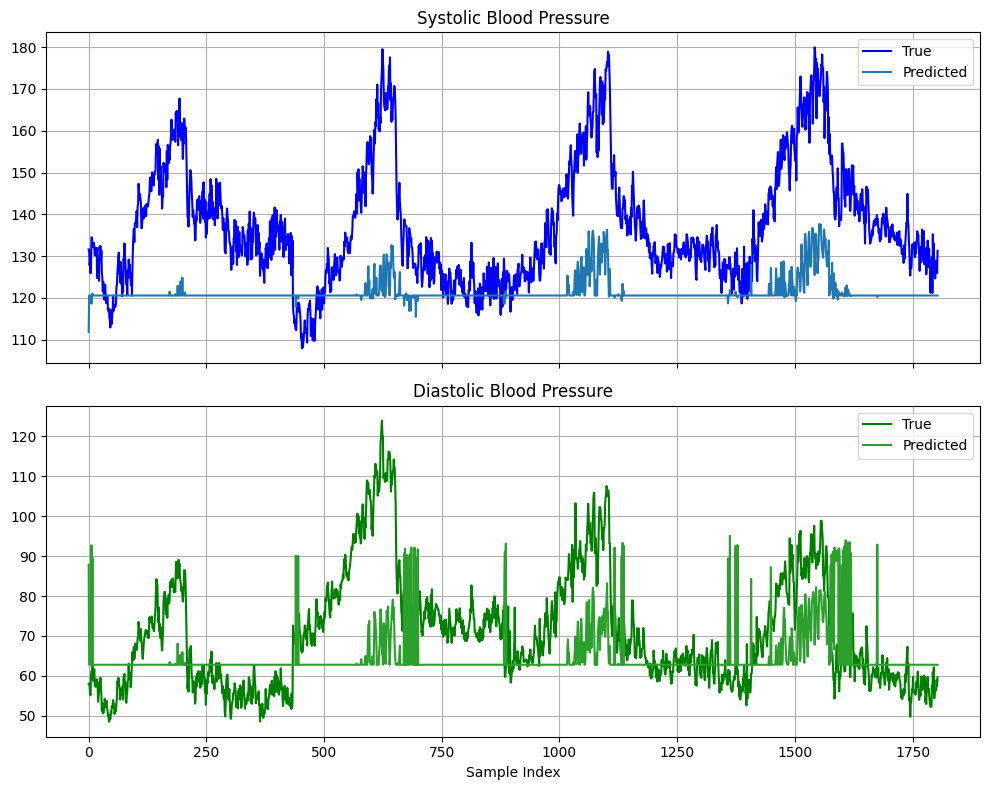

Train shape: (13847, 300), Test shape: (2200, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.5133 - mae: 0.5411 - mean_absolute_percentage_error: 342.4217 - val_loss: 5.1554 - val_mae: 1.9969 - val_mean_absolute_percentage_error: 1366.1169
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3571 - mae: 0.4705 - mean_absolute_percentage_error: 335.2373 - val_loss: 5.4848 - val_mae: 2.1605 - val_mean_absolute_percentage_error: 1761.3380
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3385 - mae: 0.4580 - mean_absolute_percentage_error: 337.8288 - val_loss: 5.6311 - val_mae: 2.2079 - val_mean_absolute_percentage_error: 1860.6154
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3221 - mae: 0.4456 - mean_absolute_percentage_error: 326.0672 - val_loss: 6.9031 - val_mae: 2.4981 - val_mean_absolute_percentage_error: 2193.1436
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3146 - mae: 0.4407 - mean_absolute_percentage_error: 324.0394 - val_loss: 5.1143 - val_mae: 2.09

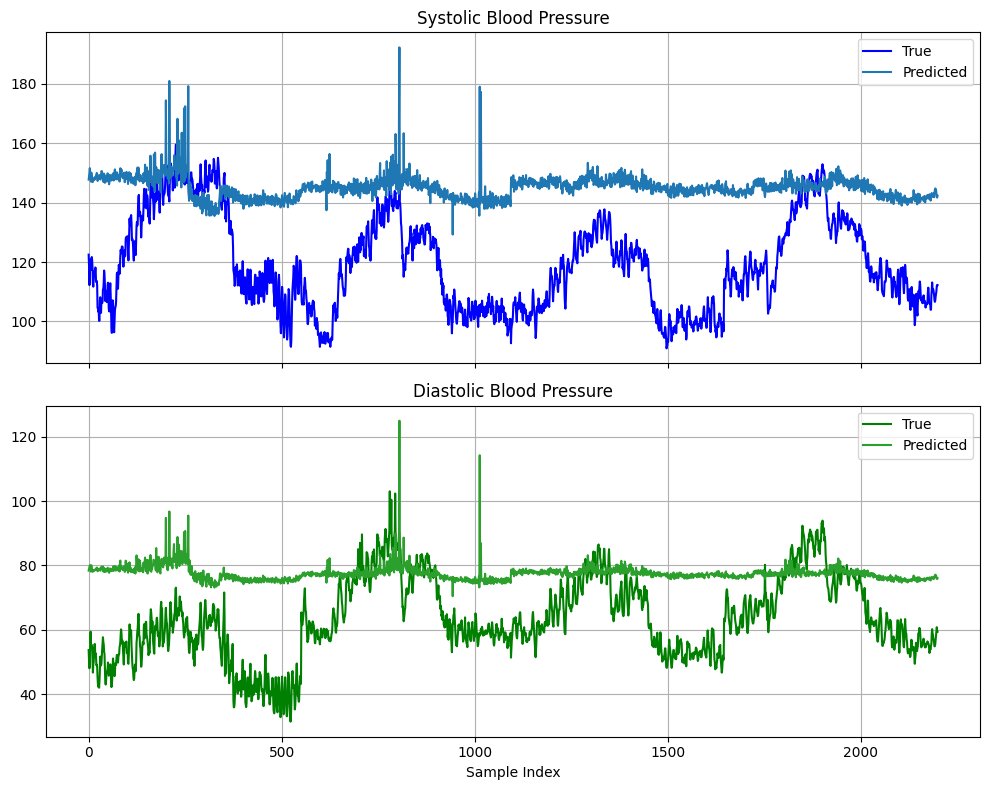

Train shape: (14100, 300), Test shape: (1947, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.5706 - mae: 0.5824 - mean_absolute_percentage_error: 405.6681 - val_loss: 1.3887 - val_mae: 0.9977 - val_mean_absolute_percentage_error: 1081.5710
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3998 - mae: 0.4939 - mean_absolute_percentage_error: 329.5743 - val_loss: 1.0438 - val_mae: 0.8294 - val_mean_absolute_percentage_error: 750.5621
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3752 - mae: 0.4774 - mean_absolute_percentage_error: 313.2431 - val_loss: 0.8152 - val_mae: 0.6729 - val_mean_absolute_percentage_error: 556.2643
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3528 - mae: 0.4618 - mean_absolute_percentage_error: 325.2693 - val_loss: 0.9907 - val_mae: 0.8051 - val_mean_absolute_percentage_error: 645.6948
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3400 - mae: 0.4538 - mean_absolute_percentage_error: 308.0300 - val_loss: 0.8368 - val_mae: 0.6994 

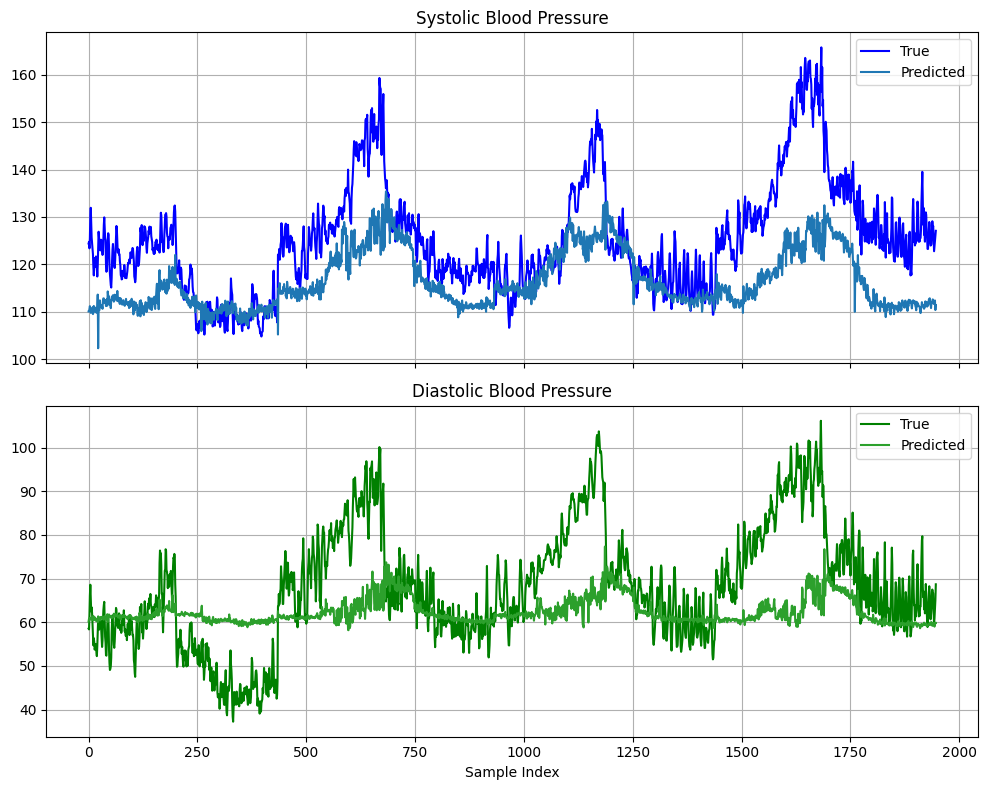

Train shape: (13681, 300), Test shape: (2366, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5605 - mae: 0.5764 - mean_absolute_percentage_error: 344.2013 - val_loss: 1.0735 - val_mae: 0.7085 - val_mean_absolute_percentage_error: 735.7953
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4066 - mae: 0.4993 - mean_absolute_percentage_error: 310.6878 - val_loss: 2.6671 - val_mae: 1.4194 - val_mean_absolute_percentage_error: 2058.9861
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3882 - mae: 0.4863 - mean_absolute_percentage_error: 323.7047 - val_loss: 1.1360 - val_mae: 0.8121 - val_mean_absolute_percentage_error: 986.4559
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3550 - mae: 0.4637 - mean_absolute_percentage_error: 325.9034 - val_loss: 1.4979 - val_mae: 0.9767 - val_mean_absolute_percentage_error: 1194.9905
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3331 - mae: 0.4490 - mean_absolute_percentage_error: 303.3617 - val_loss: 1.4227 - val_mae: 0.9677

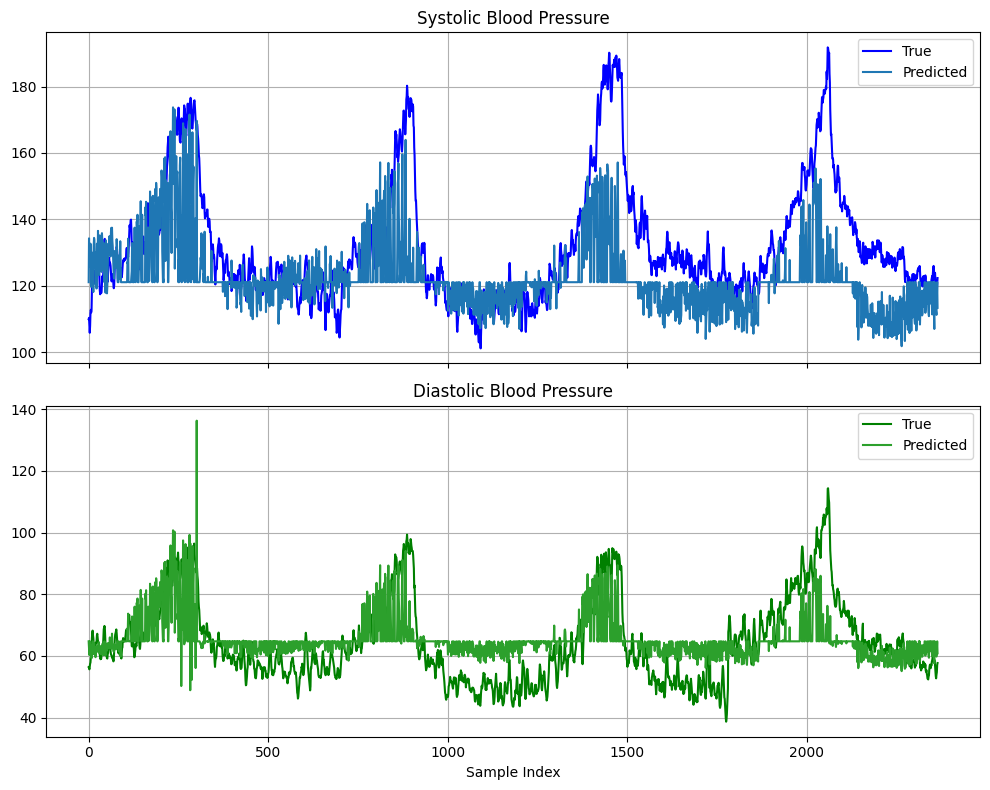

Train shape: (13894, 300), Test shape: (2153, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.5799 - mae: 0.5805 - mean_absolute_percentage_error: 411.1245 - val_loss: 1.0188 - val_mae: 0.8444 - val_mean_absolute_percentage_error: 491.5216
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3924 - mae: 0.4897 - mean_absolute_percentage_error: 372.4802 - val_loss: 0.8305 - val_mae: 0.7439 - val_mean_absolute_percentage_error: 355.1809
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3636 - mae: 0.4694 - mean_absolute_percentage_error: 355.6784 - val_loss: 0.7199 - val_mae: 0.6864 - val_mean_absolute_percentage_error: 281.0412
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3392 - mae: 0.4527 - mean_absolute_percentage_error: 354.2934 - val_loss: 0.8942 - val_mae: 0.7771 - val_mean_absolute_percentage_error: 429.0809
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3308 - mae: 0.4451 - mean_absolute_percentage_error: 350.5565 - val_loss: 0.7294 - val_mae: 0.6960 -

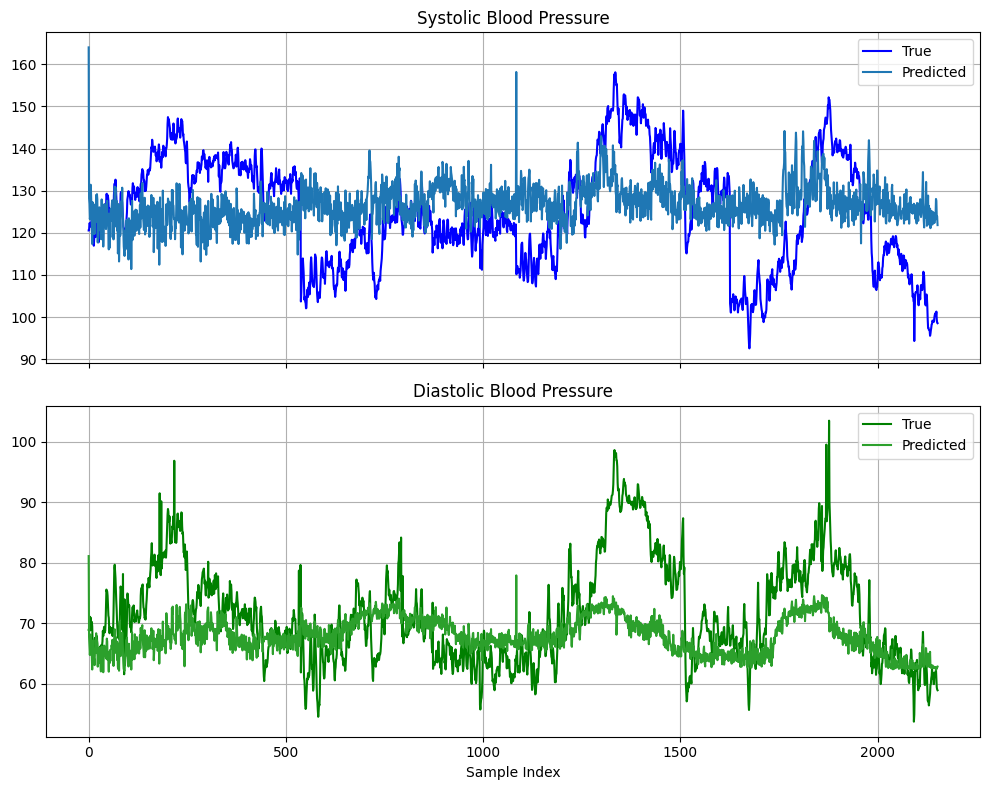

Train shape: (13986, 300), Test shape: (2061, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.5778 - mae: 0.5886 - mean_absolute_percentage_error: 367.1193 - val_loss: 0.7653 - val_mae: 0.7348 - val_mean_absolute_percentage_error: 170.4149
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4059 - mae: 0.5008 - mean_absolute_percentage_error: 349.4783 - val_loss: 0.7978 - val_mae: 0.7106 - val_mean_absolute_percentage_error: 266.3437
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3776 - mae: 0.4833 - mean_absolute_percentage_error: 349.9500 - val_loss: 2.2683 - val_mae: 1.1661 - val_mean_absolute_percentage_error: 329.4268
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3659 - mae: 0.4766 - mean_absolute_percentage_error: 359.7016 - val_loss: 1.0229 - val_mae: 0.8087 - val_mean_absolute_percentage_error: 393.8384
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3558 - mae: 0.4692 - mean_absolute_percentage_error: 347.6993 - val_loss: 1.2616 - val_mae: 0.9257 

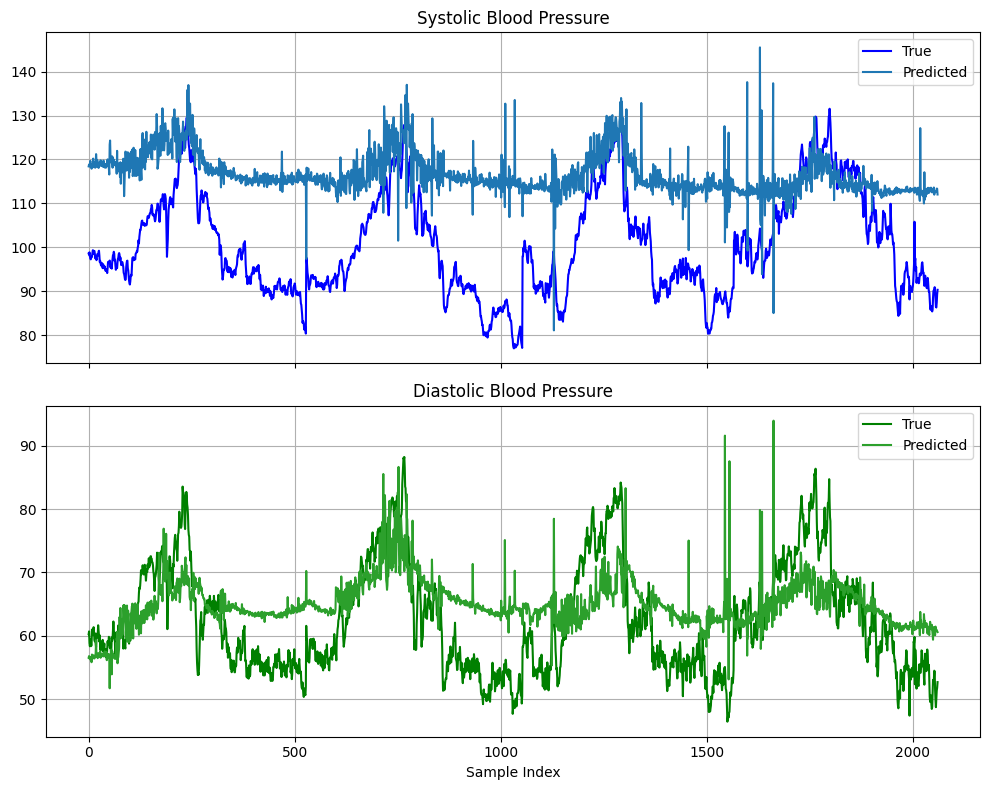

Train shape: (14467, 300), Test shape: (1580, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.5661 - mae: 0.5778 - mean_absolute_percentage_error: 403.2945 - val_loss: 0.7857 - val_mae: 0.7396 - val_mean_absolute_percentage_error: 448.4278
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3888 - mae: 0.4877 - mean_absolute_percentage_error: 363.5249 - val_loss: 0.9201 - val_mae: 0.8066 - val_mean_absolute_percentage_error: 475.1535
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3593 - mae: 0.4687 - mean_absolute_percentage_error: 344.0576 - val_loss: 0.9902 - val_mae: 0.8370 - val_mean_absolute_percentage_error: 462.5734
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3560 - mae: 0.4662 - mean_absolute_percentage_error: 346.7596 - val_loss: 0.7422 - val_mae: 0.7024 - val_mean_absolute_percentage_error: 376.8912
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3453 - mae: 0.4589 - mean_absolute_percentage_error: 347.1935 - val_loss: 0.6545 - val_mae: 0.6393 -

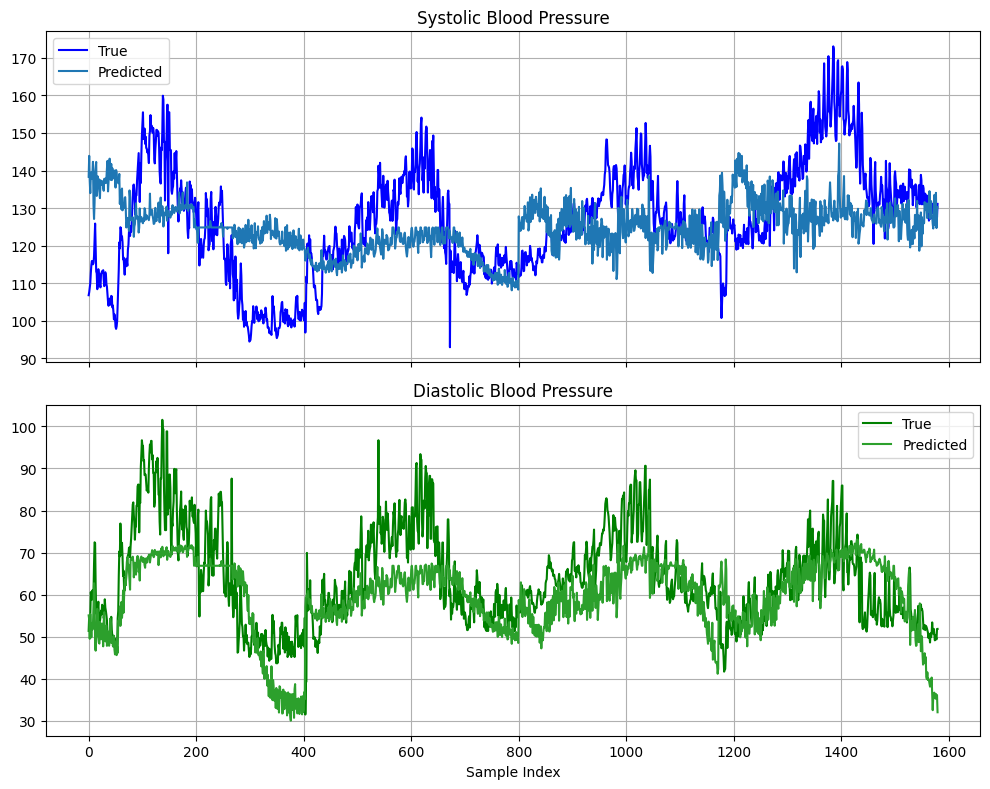

Train shape: (14111, 300), Test shape: (1936, 300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.4834 - mae: 0.5330 - mean_absolute_percentage_error: 392.5653 - val_loss: 0.8398 - val_mae: 0.7537 - val_mean_absolute_percentage_error: 247.2889
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3603 - mae: 0.4646 - mean_absolute_percentage_error: 326.5598 - val_loss: 1.4597 - val_mae: 1.0056 - val_mean_absolute_percentage_error: 397.8486
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3306 - mae: 0.4460 - mean_absolute_percentage_error: 332.3026 - val_loss: 1.2885 - val_mae: 0.9360 - val_mean_absolute_percentage_error: 349.5753
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3133 - mae: 0.4340 - mean_absolute_percentage_error: 339.5022 - val_loss: 1.2131 - val_mae: 0.9069 - val_mean_absolute_percentage_error: 321.8013
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3102 - mae: 0.4322 - mean_absolute_percentage_error: 347.0434 - val_loss: 1.0857 - val_mae: 0.8484 -

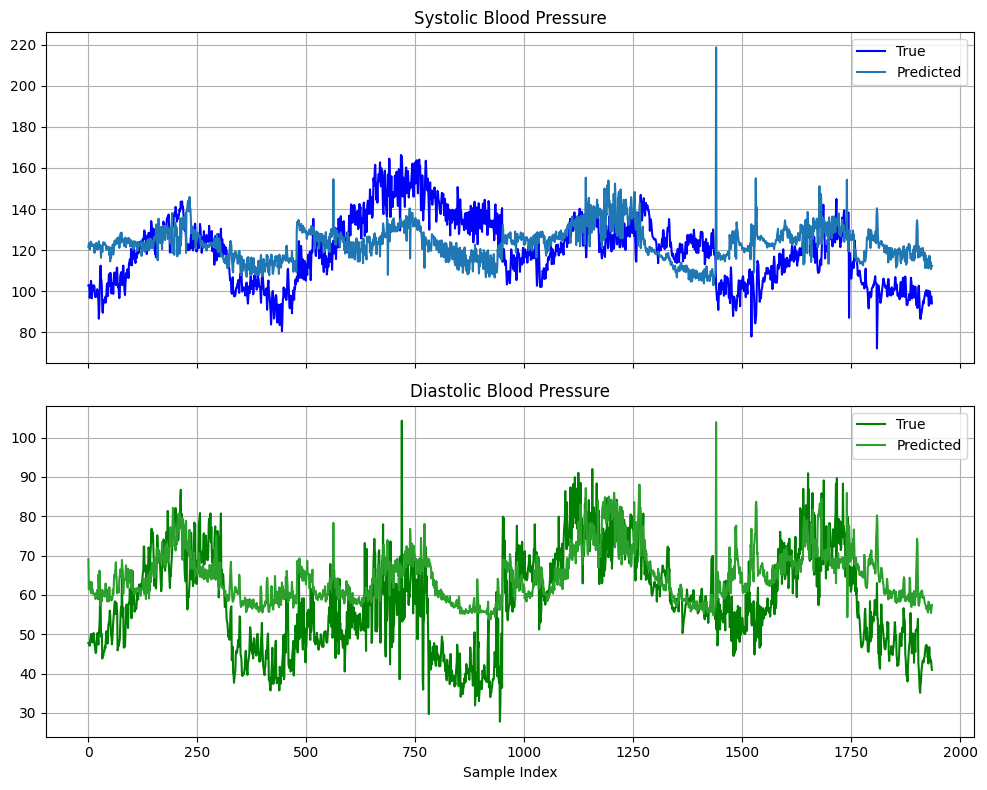

In [20]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

for train_idx, test_idx in logo.split(X, y, groups=groups):
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    print(f'Train shape: {X_train.shape}, Test shape: {X_val.shape}')

    # define reluthe model
    model = Sequential([
        Input(shape=(300,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(2)
    ])
    
    optimizer = Adam(learning_rate=0.01)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    print(model.summary())
    
    # early stopping callback
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop]
    )
    
    # Rescale predictions back to original scale
    y_pred = model.predict(X_val)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_val_rescaled = scaler_y.inverse_transform(y_val)

    # Evaluate on the original scale
    mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    mape = mean_absolute_percentage_error(y_val_rescaled, y_pred_rescaled)
    loss = mean_squared_error(y_val_rescaled, y_pred_rescaled)
    
    print(f'Test Loss: {loss:.4f} - Test MAE: {mae:.4f} - Test MAPE: {mape:.4f}')

    # plot predictions
    plot_predictions(y_pred_rescaled, y_val_rescaled)

    calc_error_avg_bp(y_pred_rescaled, y_val_rescaled)

    # clear memory
    del model
    tf.keras.backend.clear_session()



In [ ]:
# reshape to (samples, timesteps, features)
X = X.reshape((-1, 3, 100))
X = np.transpose(X, (0, 2, 1))
X.shape, y.shape

In [ ]:
param_grid = {
        'CLASSIFICADOR': 'LSTM',
        'RECURRENT_LAYERS': (64, 32),
        'DENSE_LAYERS': (64, 32),
        'BATCH_SIZE': 32,
        'LEARNING_RATE': 0.01,
        'EPOCHS': 100,
        'ACTIVATION': 'relu',
        'OPTIMIZER': 'adam'
    }

In [ ]:
logo = LeaveOneGroupOut()

In [ ]:
for train_idx, test_idx in logo.split(X, y, groups=groups):
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    print(f'Train shape: {X_train.shape}, Test shape: {X_val.shape}')

    # define the model
    model = Sequential([
        Input(shape=(300,)),
        Dense(param_grid['DENSE_LAYERS'][0], activation='relu'),
        Dense(2, activation='linear')
    ])
    
    # Choose optimizer with learning rate
    if param_grid['OPTIMIZER'] == 'adam':
        optimizer = Adam(learning_rate=param_grid['LEARNING_RATE'])
    elif param_grid['OPTIMIZER'] == 'sgd':
        optimizer = SGD(learning_rate=param_grid['LEARNING_RATE'])

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    print(model.summary())
    
    # early stopping callback
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=param_grid['EPOCHS'],
        batch_size=param_grid['BATCH_SIZE'],
        callbacks=[early_stop]
    )
    
    # Rescale predictions back to original scale
    y_pred = model.predict(X_val)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_val_rescaled = scaler_y.inverse_transform(y_val)

    # Evaluate on the original scale
    mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    mape = mean_absolute_percentage_error(y_val_rescaled, y_pred_rescaled)
    loss = mean_squared_error(y_val_rescaled, y_pred_rescaled)
    
    print(f'Test Loss: {loss:.4f} - Test MAE: {mae:.4f} - Test MAPE: {mape:.4f}')

    # plot predictions
    plot_predictions(y_pred_rescaled, y_val_rescaled)

    # clear memory
    del model
    tf.keras.backend.clear_session()
